In [1]:
import numpy as np
import numpy
from nbodykit.lab import BigFileMesh, BigFileCatalog
from pmesh.pm import ParticleMesh
import os, sys
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

from nbodykit.cosmology import Cosmology, EHPower, Planck15

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/dask/context.py:23: UserWarning: The dask.set_options function has been deprecated. Please use dask.config.set instead
  warnings.warn("The dask.set_options function has been deprecated. "


In [2]:
import tensorflow as tf
# tf.enable_eager_execution()

In [3]:
sys.path.append('../code/utils/')
import tools
from background import *
from tfpm import *
from tfpmfuncs import *
from fpmfuncs import *
from fpm import *
from pmconfig import Config


In [4]:
state = fastpm()

/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/nbodykit/cosmology/power/linear.py:228: FutureWarning: NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'
  warnings.warn("NoWiggleEHPower is deprecated. Use LinearPower with transfer set to 'EisensteinHu'", FutureWarning)


Step F 0.1000 - (0.1000) -> 0.1000 S 0.1000 P 0.1000 F 0.1000
Step K 0.1000 - (0.1000) -> 0.1803 S 0.1000 P 0.1803 F 0.1000
Step D 0.1000 - (0.1803) -> 0.3250 S 0.3250 P 0.1803 F 0.1000
Step F 0.1000 - (0.3250) -> 0.3250 S 0.3250 P 0.1803 F 0.3250
Step K 0.1803 - (0.3250) -> 0.3250 S 0.3250 P 0.3250 F 0.3250
Step K 0.3250 - (0.3250) -> 0.4228 S 0.3250 P 0.4228 F 0.3250
Step D 0.3250 - (0.4228) -> 0.5500 S 0.5500 P 0.4228 F 0.3250
Step F 0.3250 - (0.5500) -> 0.5500 S 0.5500 P 0.4228 F 0.5500
Step K 0.4228 - (0.5500) -> 0.5500 S 0.5500 P 0.5500 F 0.5500
Step K 0.5500 - (0.5500) -> 0.6529 S 0.5500 P 0.6529 F 0.5500
Step D 0.5500 - (0.6529) -> 0.7750 S 0.7750 P 0.6529 F 0.5500
Step F 0.5500 - (0.7750) -> 0.7750 S 0.7750 P 0.6529 F 0.7750
Step K 0.6529 - (0.7750) -> 0.7750 S 0.7750 P 0.7750 F 0.7750
Step K 0.7750 - (0.7750) -> 0.8803 S 0.7750 P 0.8803 F 0.7750
Step D 0.7750 - (0.8803) -> 1.0000 S 1.0000 P 0.8803 F 0.7750
Step F 0.7750 - (1.0000) -> 1.0000 S 1.0000 P 0.8803 F 1.0000
Step K 0

# Check lptz0

In [5]:
conf = Config()
bs, nc = conf['boxsize'], conf['nc']
pm = conf.pm

# bs = 100
# nc = 32
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
solver = Solver(pm, conf['cosmology'])
conf['kvec'] = kvec
gdict = conf


whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: mode argument is deprecated, use type


In [6]:
lptdisp = lptz0(lineark, grid, order=2)
lptpos = grid + lptdisp
lptmesh =  pm.paint(lptpos)


In [7]:
# #
# tlinear = tf.constant(linear[...])
# tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)
tlptmesh = tf.zeros_like(tlinear)
wt = tf.ones(nc**3)
# wt = np.ones(nc**3, dtype=np.float32)
tlptdisp = tflptz0(tlineark, grid, gdict, order=2)
tlptpos = tf.add(grid, tlptdisp)
tlptmesh = cic_paint(tlptmesh, tf.multiply(tlptpos, nc/bs), weight=wt)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tflptpos, tflptmesh = sess.run([tlptpos, tlptmesh])

In [8]:
tflptpos-lptpos

array([[ 2.3841858e-06, -1.1920929e-07, -1.1920929e-06],
       [ 2.8610229e-06,  0.0000000e+00, -1.9073486e-06],
       [ 9.5367432e-07,  2.3841858e-06, -9.5367432e-07],
       ...,
       [ 0.0000000e+00,  0.0000000e+00,  7.6293945e-06],
       [ 0.0000000e+00,  0.0000000e+00,  7.6293945e-06],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

Text(0.5,1,'Yu 2LPT')

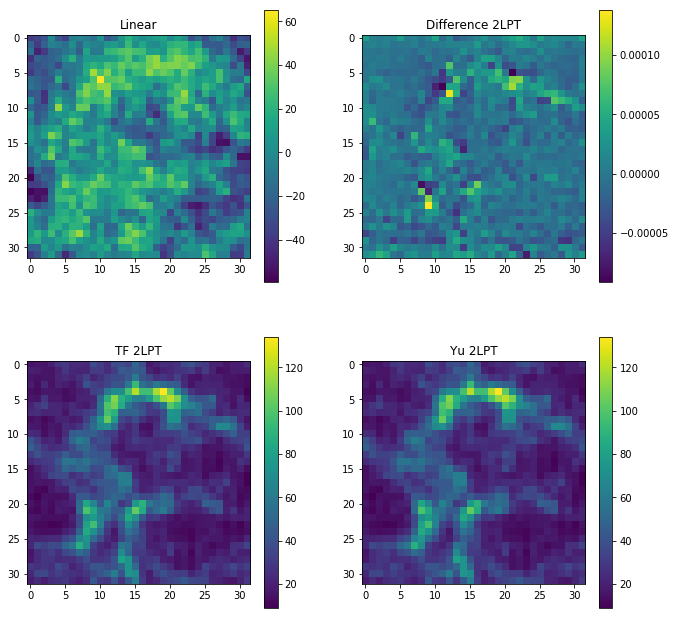

In [9]:
fig, axar = plt.subplots(2, 2, figsize = (11, 11))
ax = axar[0]
im = ax[0].imshow(linear[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Linear')
im = ax[1].imshow((lptmesh-tflptmesh)[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Difference 2LPT')
ax = axar[1]
im = ax[0].imshow(tflptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('TF 2LPT')
im = ax[1].imshow(lptmesh[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('Yu 2LPT')



# FastPM

In [11]:
a0, a1 = conf['stages'][0], conf['stages'][1]
ah = (a0*a1)**0.5

### lpt IC

In [12]:
# #
statelpt = solver.lpt(lineark, grid, a0, order=2)
tflptic = tflptinit(tlineark, grid, a0, conf, order=2)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstatelpt = sess.run(tflptic)
# tfstatelpt = ttmp.copy()

In [13]:
(tfstatelpt[0])/ statelpt.X

array([[0.9999995 , 0.99999946, 0.9999995 ],
       [0.9999999 , 0.9999996 , 0.99999994],
       [0.99999964, 0.99999917, 1.        ],
       ...,
       [1.        , 1.        , 1.0000001 ],
       [1.        , 1.0000001 , 1.        ],
       [1.        , 1.        , 1.        ]], dtype=float32)

In [14]:
(tfstatelpt[0]-grid)/ statelpt.S

array([[0.9999995 , 0.99999946, 0.9999995 ],
       [0.9999999 , 0.9999996 , 0.9999996 ],
       [0.99999964, 0.99999917, 0.9999999 ],
       ...,
       [1.0000273 , 1.0000533 , 0.99999523],
       [1.0000032 , 0.9999864 , 0.9999948 ],
       [0.9999881 , 0.99999225, 0.99997836]], dtype=float32)

In [15]:
(tfstatelpt[1])/ statelpt.V, (tfstatelpt[1])/ statelpt.P

(array([[0.001     , 0.001     , 0.001     ],
        [0.001     , 0.001     , 0.001     ],
        [0.001     , 0.001     , 0.001     ],
        ...,
        [0.00099999, 0.001     , 0.001     ],
        [0.001     , 0.001     , 0.001     ],
        [0.001     , 0.001     , 0.001     ]], dtype=float32),
 array([[0.99999976, 0.9999996 , 0.9999996 ],
        [1.        , 0.9999996 , 0.99999976],
        [0.9999997 , 0.99999934, 0.9999998 ],
        ...,
        [0.9999892 , 0.99999744, 0.9999985 ],
        [0.999997  , 0.9999994 , 0.99999696],
        [0.999996  , 0.99999946, 1.0000014 ]], dtype=float32))

In [16]:
(tfstatelpt[2])/ statelpt.F

array([[0.9999999 , 0.9999997 , 0.99999946],
       [1.0000002 , 0.99999976, 0.9999998 ],
       [0.99999976, 0.9999993 , 0.9999999 ],
       ...,
       [0.9999872 , 0.99999726, 0.9999986 ],
       [0.9999969 , 0.99999964, 0.9999968 ],
       [0.99999577, 0.99999964, 1.0000014 ]], dtype=float32)

### Kick

In [17]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['F'] = ah
solver.nbodystep.Kick(state, a0, ah, a1)

# #
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [18]:
ii = 1
tfstate[ii] / tfstatelpt[ii], tfstate[ii] / state.P

(array([[3.3029625, 3.5072312, 3.6716743],
        [3.3268135, 3.5375588, 3.617562 ],
        [3.4022222, 3.5652645, 3.6051776],
        ...,
        [3.0201457, 2.6887195, 3.5825615],
        [3.3393898, 3.3862796, 3.5381076],
        [2.9954386, 3.4498208, 3.799002 ]], dtype=float32),
 array([[0.9999998 , 0.9999997 , 0.99999946],
        [1.0000002 , 0.9999997 , 0.9999999 ],
        [0.99999976, 0.9999992 , 0.9999998 ],
        ...,
        [0.99998784, 0.9999974 , 0.99999857],
        [0.99999696, 0.99999964, 0.99999684],
        [0.99999577, 0.9999996 , 1.0000015 ]], dtype=float32))

### Drift

In [19]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['S'] = ah
solver.nbodystep.Force(state, a0, ah, a1)

# #
tfkicked = tfKick(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [20]:
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['P'] = ah
solver.nbodystep.Drift(state, a0, ah, a1)

# #
tfkicked = tfDrift(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)

In [21]:
ii = 0
tfstate[ii] / tfstatelpt[ii], tfstate[ii] / state.X

(array([[1.8305849 , 1.8771114 , 1.9185332 ],
        [1.8357612 , 1.8844674 , 1.1731321 ],
        [1.8525606 , 1.8912961 , 1.1251558 ],
        ...,
        [1.0003488 , 0.9996288 , 0.9911774 ],
        [1.0019221 , 0.9974347 , 0.9974991 ],
        [1.0008509 , 0.99616855, 1.0010128 ]], dtype=float32),
 array([[0.99999964, 0.9999995 , 0.9999995 ],
        [0.9999999 , 0.9999995 , 0.9999999 ],
        [0.9999997 , 0.9999992 , 1.        ],
        ...,
        [1.        , 1.        , 1.0000001 ],
        [1.        , 1.0000001 , 1.        ],
        [1.        , 1.        , 1.        ]], dtype=float32))

### Force

In [22]:
# #
state = statelpt.copy()
tfstate = tfstatelpt.copy()

state.a['S'] = ah
delk = solver.nbodystep.Force(state, a0, ah, a1)

# #
tfkicked = tfForce(tfstate, a0, ah, a1,  conf)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstate = sess.run(tfkicked)
    
#     tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
# tfforced = tfForce(tflptic, a0, ah, a1, conf)
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     ttmp0, ttmp1 = sess.run([tfforced, tflptic])

In [23]:
ii = 2
tfstate[ii] / tfstatelpt[ii], tfstate[ii] / state.F

(array([[0.825243  , 0.7041261 , 0.6076966 ],
        [0.73939   , 0.81493515, 0.84227973],
        [0.65501213, 0.92865807, 0.93659854],
        ...,
        [1.8543605 , 3.4201462 , 0.9582288 ],
        [0.6716402 , 1.146379  , 0.9854585 ],
        [1.2203827 , 1.0349008 , 0.5742638 ]], dtype=float32),
 array([[0.99999744, 0.99999374, 1.0000019 ],
        [0.999998  , 0.99999577, 1.0000007 ],
        [0.9999984 , 0.99999636, 1.0000002 ],
        ...,
        [0.99998295, 0.99999905, 0.9999961 ],
        [0.9999867 , 0.9999944 , 1.000005  ],
        [0.99997616, 1.0000004 , 0.9999765 ]], dtype=float32))

# Put it all together

In [30]:
conf = Config()
bs, nc = conf['boxsize'], conf['nc']
pm = conf.pm

# bs = 100
# nc = 32
# pm = ParticleMesh(BoxSize=bs, Nmesh = [nc, nc, nc], dtype='f4')
grid = pm.generate_uniform_particle_grid(shift=0).astype(np.float32)
kvec = tools.fftk((nc, nc, nc), bs, dtype=np.float32)
gdict = {'bs':bs, 'nc':nc, 'kvec':kvec, 'ndim':3}
solver = Solver(pm, conf['cosmology'])
conf['kvec'] = kvec
gdict = conf


whitec = pm.generate_whitenoise(100, mode='complex', unitary=False)
lineark = whitec.apply(lambda k, v:Planck15.get_pklin(sum(ki ** 2 for ki in k)**0.5, 0) ** 0.5 * v / v.BoxSize.prod() ** 0.5)
linear = lineark.c2r()
tlinear = tf.constant(linear[...])
tlineark = tf.multiply(tf.spectral.rfft3d(tlinear), 1/nc**3)



/global/homes/c/chmodi/.conda/envs/fastpm/lib/python3.6/site-packages/ipykernel/__main__.py:16: DeprecationWarning: mode argument is deprecated, use type


In [31]:
# state = statelpt.copy()
# tfstate = tfstatelpt.copy()
# #
state = solver.lpt(lineark, grid, a0, order=2)
solver.nbody(state, leapfrog(conf['stages']))

tflptic = tflptinit(tlineark, grid, a0, conf, order=2)
tfstate = tfnbody(tflptic, conf)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfstatepm = sess.run(tfstate)


F 0.1 0.1 0.1
K 0.1 0.1 0.18027756377319948
D 0.1 0.18027756377319948 0.325
F 0.1 0.325 0.325
K 0.18027756377319948 0.325 0.325
K 0.325 0.325 0.4227883631321941
D 0.325 0.4227883631321941 0.55
F 0.325 0.55 0.55
K 0.4227883631321941 0.55 0.55
K 0.55 0.55 0.6528782428600298
D 0.55 0.6528782428600298 0.775
F 0.55 0.775 0.775
K 0.6528782428600298 0.775 0.775
K 0.775 0.775 0.8803408430829505
D 0.775 0.8803408430829505 1.0
F 0.775 1.0 1.0
K 0.8803408430829505 1.0 1.0


In [32]:
tfmesh = tf.zeros((nc, nc, nc))
tfmesh = cic_paint(tfmesh, tf.multiply(tfstatepm[0], nc/bs), weight=tf.ones(nc**3))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfmeshpm = sess.run(tfmesh)


In [33]:
meshpm = pm.paint(state.X)

Text(0.5,1,'Difference')

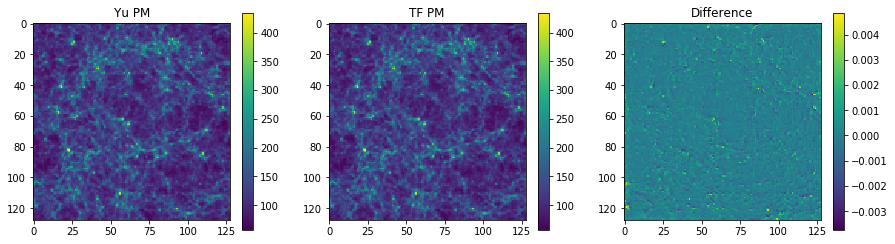

In [34]:
fig, ax = plt.subplots(1, 3, figsize = (15, 4))
im = ax[0].imshow(meshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[0])
ax[0].set_title('Yu PM')
im = ax[1].imshow(tfmeshpm[...].sum(axis=0))
plt.colorbar(im, ax=ax[1])
ax[1].set_title('TF PM')
im = ax[2].imshow((meshpm-tfmeshpm)[...].sum(axis=0))
plt.colorbar(im, ax=ax[2])
ax[2].set_title('Difference')
